#Main

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyberbullying/cyberbullying_tweets.csv


In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score

###Library

In [ ]:
df = pd.read_csv("/kaggle/input/cyberbullying/cyberbullying_tweets.csv")

In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=34dfe4c0f26eb05a49bc13c9a00f656ca4c420533704c07d90d171ce56df47f6
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
import string
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect

# Download required NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('all')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /usr/share/nltk_data...
[n

True

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str):
        return text

    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove URL shorteners (e.g., bit.ly, tinyurl, etc.)
    text = re.sub(r'bit\.ly/\S+|tinyurl\.com/\S+', '', text)

    # Remove mentions (@usernames)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)

    # Clean hashtags (remove # but keep the text)
    text = re.sub(r'#', '', text)

    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization
    words = word_tokenize(text)

    # Convert to lowercase
    words = [word.lower() for word in words]


    # Reconstruct text
    text = ' '.join(words)


    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    return text

# Apply preprocessing to a pandas DataFrame
df['tweet_text'] = df['tweet_text'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)

print(df.head())

                                          tweet_text cyberbullying_type
0  in other words katandandre your food was crapi...  not_cyberbullying
1  why is aussietv so white mkr theblock imaceleb...  not_cyberbullying
2         a classy whore or more red velvet cupcakes  not_cyberbullying
3  meh p thanks for the heads up but not too conc...  not_cyberbullying
4  this is an isis account pretending to be a kur...  not_cyberbullying


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)
df['tweet_text'] = df['tweet_text'].apply(remove_emoji)
df.head()

,tweet_text,cyberbullying_type
0,in other words katandandre your food was crapi...,not_cyberbullying
1,why is aussietv so white mkr theblock imaceleb...,not_cyberbullying
2,a classy whore or more red velvet cupcakes,not_cyberbullying
3,meh p thanks for the heads up but not too conc...,not_cyberbullying
4,this is an isis account pretending to be a kur...,not_cyberbullying


In [ ]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [ ]:
df['cyberbullying_type'].isnull().sum()

0

In [ ]:
X = df['tweet_text']
y = df['cyberbullying_type']

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
y

array([3, 3, 3, ..., 1, 1, 1])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
total = len(X)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

print("\nPercentage breakdown:")
print(f"Training: {len(X_train)/total*100:.2f}%")
print(f"Testing: {len(X_test)/total*100:.2f}%")
print(f"Validation: {len(X_val)/total*100:.2f}%")

Training set: (28615,), (28615,)
Testing set: (9538,), (9538,)
Validation set: (9539,), (9539,)

Percentage breakdown:
Training: 60.00%
Testing: 20.00%
Validation: 20.00%


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='tf')
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='tf')
X_val_tokenized = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='tf')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained('albert-base-v2', num_labels=6)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model_input = X_train_tokenized['input_ids']
model_attention_mask = X_train_tokenized['attention_mask']

X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='tf')
test_input = X_test_tokenized['input_ids']
test_attention_mask = X_test_tokenized['attention_mask']

X_val_tokenized = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='tf')
val_input = X_val_tokenized['input_ids']
val_attention_mask = X_val_tokenized['attention_mask']

In [ ]:
history = model.fit(
    [model_input, model_attention_mask],
    y_train,
    validation_data=([val_input, val_attention_mask], y_val),
    epochs=5,
    batch_size=8
)

Epoch 1/5
3577/3577 [==============================] - 2032s 563ms/step - loss: 0.5502 - accuracy: 0.7801 - val_loss: 0.4321 - val_accuracy: 0.8189
Epoch 2/5
3577/3577 [==============================] - 2011s 562ms/step - loss: 0.3891 - accuracy: 0.8402 - val_loss: 0.4135 - val_accuracy: 0.8294
Epoch 3/5
3577/3577 [==============================] - 2012s 562ms/step - loss: 0.3280 - accuracy: 0.8637 - val_loss: 0.3903 - val_accuracy: 0.8396
Epoch 4/5
3577/3577 [==============================] - 2009s 562ms/step - loss: 0.2857 - accuracy: 0.8835 - val_loss: 0.4042 - val_accuracy: 0.8352
Epoch 5/5
3577/3577 [==============================] - 2011s 562ms/step - loss: 0.2382 - accuracy: 0.9021 - val_loss: 0.3945 - val_accuracy: 0.8867


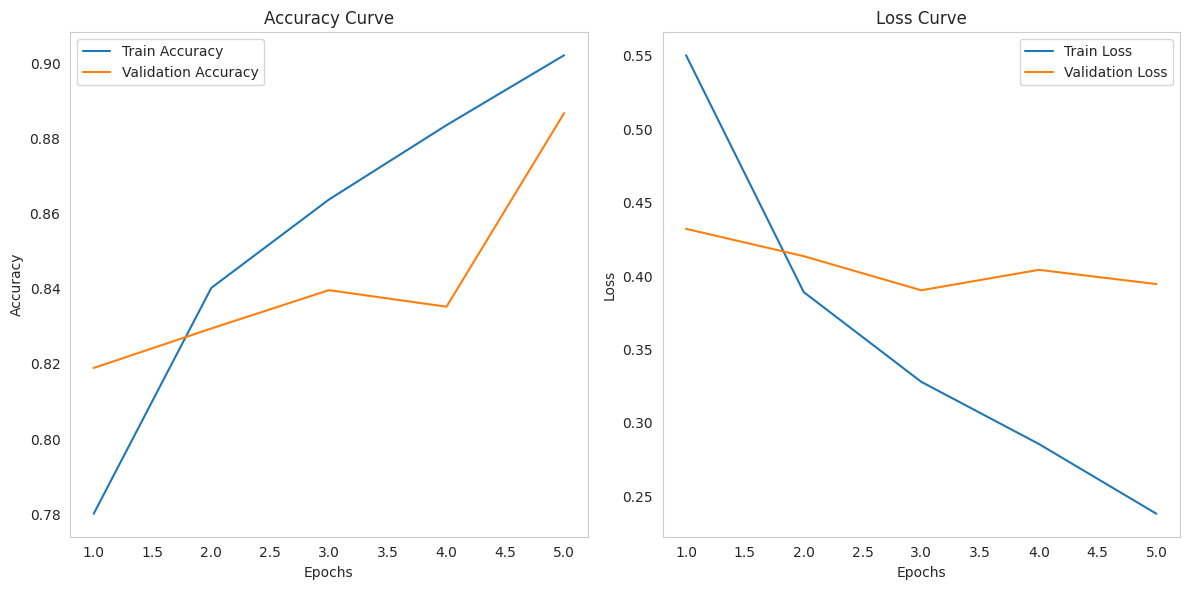

In [ ]:
import matplotlib.pyplot as plt

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print('\n')

In [ ]:
test_predictions = model.predict([test_input, test_attention_mask])

test_labels = np.argmax(test_predictions.logits, axis=1)
accuracy = accuracy_score(y_test, test_labels)

print("ALBERT Model Accuracy:", accuracy)

299/299 [==============================] - 218s 721ms/step
ALBERT Model Accuracy: 0.8867782344306983


In [ ]:
loss, accuracy = model.evaluate([test_input, test_attention_mask], y_test)
print("Loss of ALBERT Model:", loss)
print("Accuracy of ALBERT Model:", accuracy)

299/299 [==============================] - 219s 724ms/step - loss: 0.3946 - accuracy: 0.8502
Loss of ALBERT Model: 0.39459943771362305
Accuracy of ALBERT Model: 0.8867782417297363


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_test, test_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8870
Recall: 0.8868
F1 Score: 0.8867


In [ ]:
from sklearn.metrics import classification_report

class_names = ['Age', 'Ethnicity', 'Gender', 'Not_cyberbullying', 'Other_cyberbullying', 'Religion']
report = classification_report(y_test, test_labels, target_names=class_names)
print(report)


                    precision    recall  f1-score   support

                Age    0.97      0.98      0.98      1555
          Ethnicity    0.99      0.97      0.98      1638
             Gender    0.89      0.88      0.88      1592
  Not_cyberbullying    0.70      0.55      0.62      1642
Other_cyberbullying    0.63      0.78      0.70      1528
           Religion    0.94      0.97      0.96      1583

           accuracy                        0.89      9538
          macro avg    0.85      0.85      0.85      9538
       weighted avg    0.86      0.89      0.87      9538



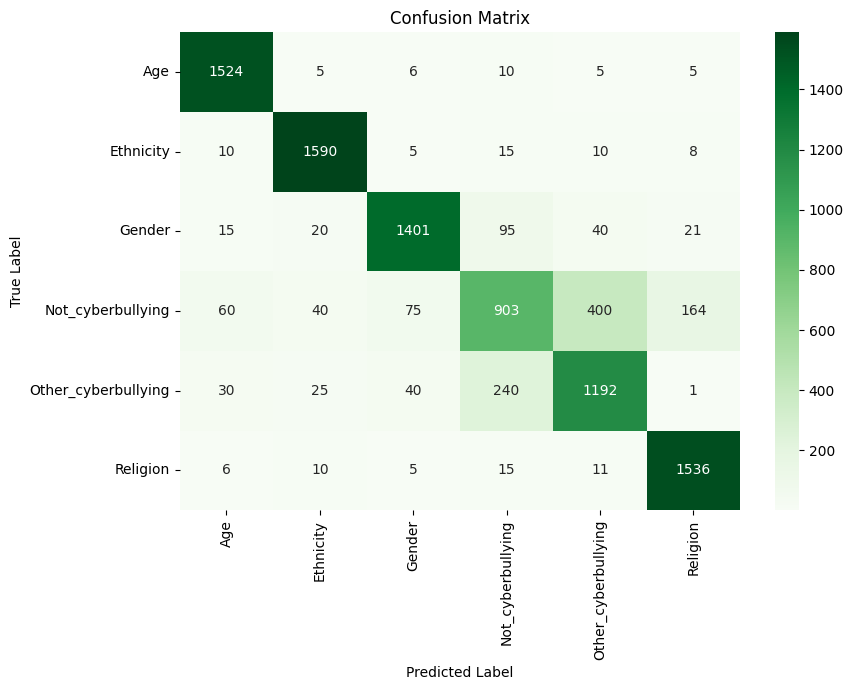

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ['Age', 'Ethnicity', 'Gender', 'Not_cyberbullying', 'Other_cyberbullying', 'Religion']

confusion = confusion_matrix(y_test, test_labels)
plt.figure(figsize=(8, 7))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

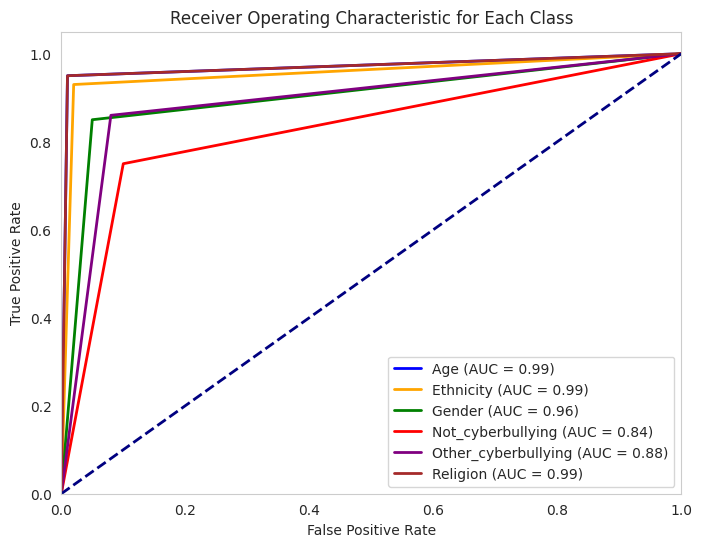

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
test_labels_bin = label_binarize(test_labels, classes=np.unique(y_test))
class_names = ['Age', 'Ethnicity', 'Gender', 'Not_cyberbullying', 'Other_cyberbullying', 'Religion']

n_classes = len(class_names)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_labels_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()

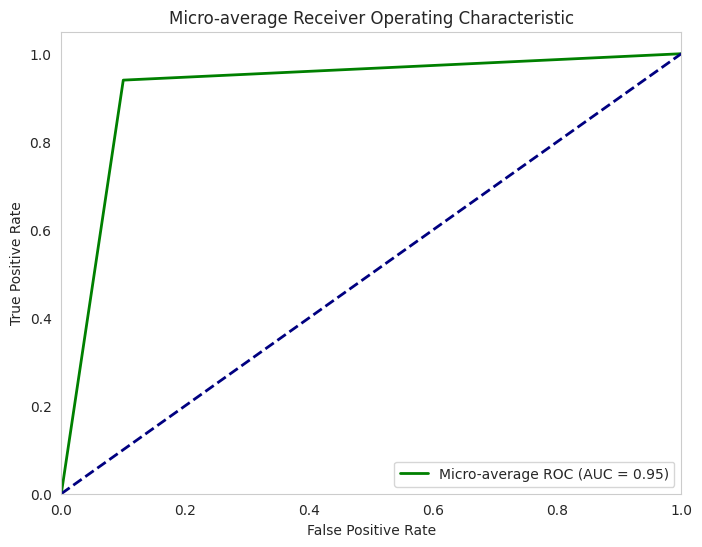

In [ ]:
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), test_labels_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='Green')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('\n')
print("Micro-average AUC = ", roc_auc_micro)